In [84]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
import shap
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [85]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [86]:
train = pd.read_csv('../data/train_concat.csv')

ex1 = pd.read_csv('../data_0220_2024/data_0307.csv', encoding='cp949')

In [87]:
ex1.columns = ['연구등록번호', '(실명)등록번호', 'age', 'sex', 'HTN', 'DM', 'tpro', 'alb', 'chol',
       'bun', 'cr', 'eGFR', 'glu', 'plt', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_', 'pcr_urine', 'Dysmorphic RBC',
       'G1 dysmorphic', 'glu_urine', 'esterase_urine', 'RBC', 'WBC', 'Biopsy',
       'Reason']
ex1.columns

Index(['연구등록번호', '(실명)등록번호', 'age', 'sex', 'HTN', 'DM', 'tpro', 'alb', 'chol',
       'bun', 'cr', 'eGFR', 'glu', 'plt', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_', 'pcr_urine', 'Dysmorphic RBC', 'G1 dysmorphic',
       'glu_urine', 'esterase_urine', 'RBC', 'WBC', 'Biopsy', 'Reason'],
      dtype='object')

In [88]:
ex_copy = ex1[['age', 'sex', 'HTN', 'DM', 'plt', 'alb',
       'bun', 'cr', 'eGFR', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_urine', 'glu', 'RBC', 'WBC','Biopsy']].copy()
print(ex_copy.columns)
ex_copy.head()

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC', 'Biopsy'],
      dtype='object')


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,20,2,1
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,1
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0


In [89]:
print(train.shape)

print(ex_copy.shape)
ex_copy.Biopsy.value_counts()

(18513, 25)
(632, 17)


Biopsy
0    527
1    105
Name: count, dtype: int64

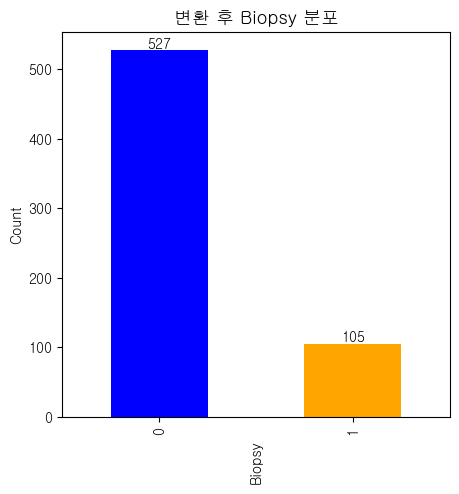

In [90]:
import matplotlib.pyplot as plt

# Bar plot of ex_copy.Biopsy
plt.figure(figsize=(5, 5))
ax = ex_copy['Biopsy'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Biopsy', rotation='vertical')
plt.ylabel('Count')

# Add count labels
for i, count in enumerate(ex_copy['Biopsy'].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('변환 후 Biopsy 분포', fontsize=13)
plt.show()


In [91]:
train.drop(['group'], axis=1, inplace=True)

print(train.shape)

print(ex_copy.shape)

(18513, 24)
(632, 17)


In [92]:
train_columns = set(train.columns)
ex1_columns = set(ex_copy.columns)

variable_difference = train_columns - ex1_columns
print(f"train 변수에서 validation 변수 제외한 변수들:{list(variable_difference)}")

train 변수에서 validation 변수 제외한 변수들:['WBC_binary', 'glu_urine', 'WBC_re', 'RBC_binary', 'esterase_urine', 'esterase_binary', 'RBC_re', 'dysmorphism', 'target', 'tpro']


In [93]:
# # ex_copy
# ex_copy['RBC_re'] = ex_copy['RBC'].apply(lambda x: 1 if 1 > x else 2 if 5> x >= 1 else 3 if 10 > x >= 5 else
#                                      4 if 20 > x >= 10 else 5 if 30 > x >= 20 else 6 if 40 > x >= 30 else 
#                                      7 if x >= 40 else x)

# ex_copy['WBC_re'] = ex_copy['WBC'].apply(lambda x: 1 if 1 > x else 2 if 5> x >= 1 else 3 if 10 > x >= 5 else
#                                      4 if 20 > x >= 10 else 5 if 30 > x >= 20 else 6 if 40 > x >= 30 else 
#                                      7 if x >= 40 else x)

In [94]:
print(train.shape)

train.columns = ['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'target']

(18513, 24)


In [95]:
print(ex_copy['WBC'].value_counts())
ex_copy['RBC'].value_counts()

WBC
2     471
5      80
20     28
10     24
30     24
0       4
3       1
Name: count, dtype: int64


RBC
2     411
5      77
30     71
20     38
10     35
Name: count, dtype: int64

In [96]:
test = ex_copy.drop(['Biopsy'], axis=1)
test.head()

,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,20,2
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2


## Modeling

In [97]:
xgb = XGBClassifier(random_state = 2023, n_jobs=-1)

In [98]:
print(test.columns)
print(train.columns)

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'target'],
      dtype='object')


In [99]:
column_difference = set(ex_copy.columns).difference(set(train.columns))
print(f'val - train:{column_difference}')

column_difference = set(train.columns).difference(set(ex_copy.columns))
print(f'train - val:{column_difference}')

val - train:{'Biopsy'}
train - val:{'WBC_binary', 'glu_urine', 'RBC_binary', 'esterase_urine', 'esterase_binary', 'dysmorphism', 'target', 'tpro'}


In [100]:
X_train = train.drop(['tpro', 'esterase_urine', 'RBC_binary', 'dysmorphism',
                      'esterase_binary', 'glu_urine', 'WBC_binary', 'target'], axis=1).copy()
y_train = train['target'].copy()

In [101]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=2023, ...)

### test

In [102]:
test_pred = xgb.predict(test)
test_pred_prob = xgb.predict_proba(test)

In [103]:
ex_copy['pred'] = test_pred
ex_copy['pred_prob_1'] = test_pred_prob[:,1]
ex_copy['pred_prob_0'] = test_pred_prob[:,0]

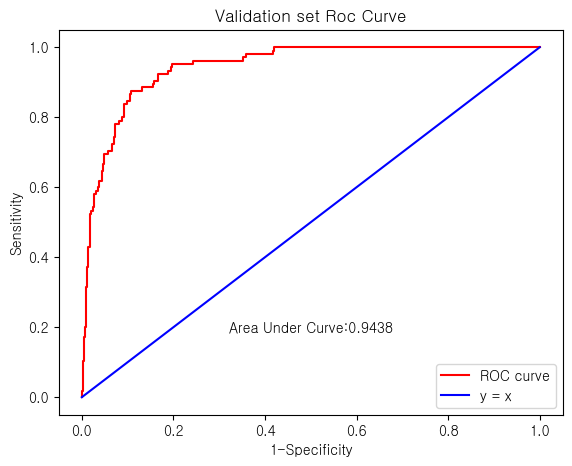

In [104]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy['Biopsy']), test_pred_prob[:,1])

plt.figure(figsize=(6.5, 5))
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy['Biopsy']), test_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)

plt.title('Validation set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.legend() # 그래프 라벨 표시

plt.show()

In [105]:
accuracy = accuracy_score(ex_copy['Biopsy'], test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.40%


In [106]:
print(classification_report(ex_copy['Biopsy'], test_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       527
           1       0.83      0.46      0.59       105

    accuracy                           0.89       632
   macro avg       0.86      0.72      0.76       632
weighted avg       0.89      0.89      0.88       632



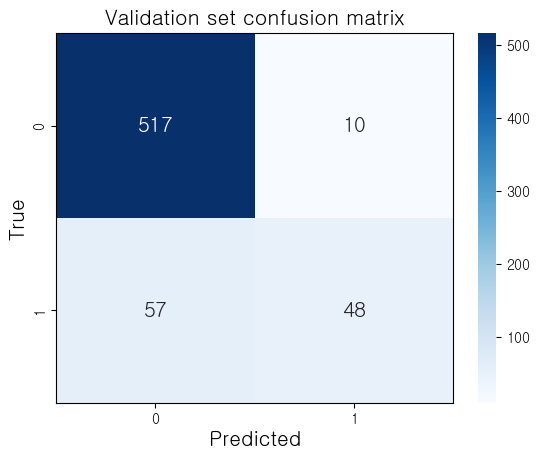

In [107]:
cm = confusion_matrix(ex_copy['Biopsy'], test_pred)

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('Validation set confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

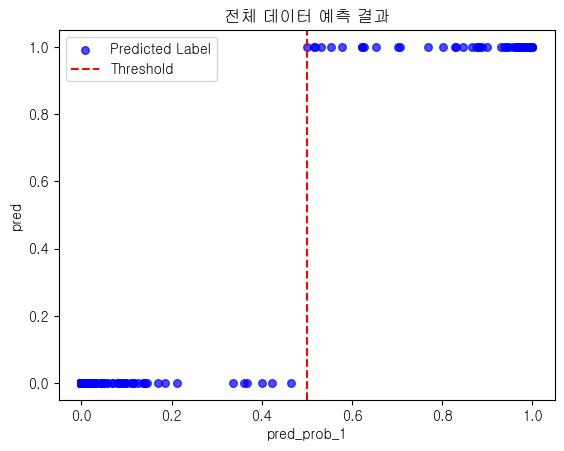

In [108]:
plt.scatter(ex_copy['pred_prob_1'], ex_copy['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob_1')
plt.ylabel('pred')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.show()

In [109]:
# from scipy.interpolate import interp1d

# # 데이터 포인트를 예측 확률에 따라 정렬
# sorted_indices = np.argsort(test_pred_prob[:,1])
# sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
# sorted_ex_copy_pred = test_pred[sorted_indices]

# # 보간 함수 생성
# f = interp1d(sorted_ex_copy_pred_prob, sorted_ex_copy_pred, kind='cubic')

# # 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
# x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
# y_smooth = f(x_new)


# # 그래프 그리기
# plt.figure(figsize=(10,5))
# plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
# plt.plot(x_new, y_smooth, color='blue', label='Smooth S-Curve')

# # 기타 그래프 설정
# plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
# plt.xlabel('pred_prob')
# plt.ylabel('pred')
# plt.title('전체 데이터 예측 결과')
# plt.legend()
# plt.grid(True)
# plt.show()


In [110]:
# from scipy.interpolate import PchipInterpolator

# # 데이터 포인트를 예측 확률에 따라 정렬
# sorted_indices = np.argsort(test_pred_prob[:,1])
# sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
# sorted_ex_copy_pred = test_pred[sorted_indices]

# # PchipInterpolator를 사용하여 보간 객체 생성
# f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# # 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
# x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
# y_smooth = f(x_new)

# # 그래프 그리기
# plt.figure(figsize=(10,5))
# plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
# plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# # 기타 그래프 설정
# plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
# plt.xlabel('predicted probability')
# plt.ylabel('Predicted label')
# plt.title('전체 데이터 예측 결과')
# plt.legend()
# plt.grid(True)
# plt.show()

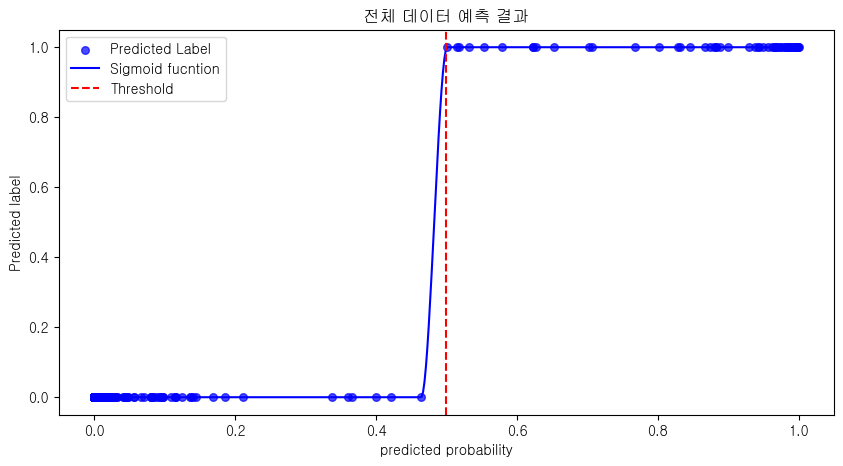

In [111]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 10% 중간 영역 제외

In [112]:
ex_copy.pred_prob_1.head()

0    0.464096
1    0.996576
2    0.000010
3    0.000205
4    0.000026
Name: pred_prob_1, dtype: float32

In [113]:
# 8개 제외됨
ex_copy_no_middle_10 = ex_copy[(ex_copy['pred_prob_1'] < 0.45) | (ex_copy['pred_prob_1'] > 0.55)].copy()
print(ex_copy_no_middle_10.shape)
ex_copy_no_middle_10.head()

(627, 20)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,pred,pred_prob_1,pred_prob_0
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,1,1,0.996576,0.003424
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0,0,0.000010,0.999990
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0,0,0.000205,0.999795
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0,0,0.000026,0.999974
5,60,1,0,0,255,5.1,13.2,0.95,86.653354,0.0,3.0,868.3,1.3104,114,2,5,1,1,0.976329,0.023671


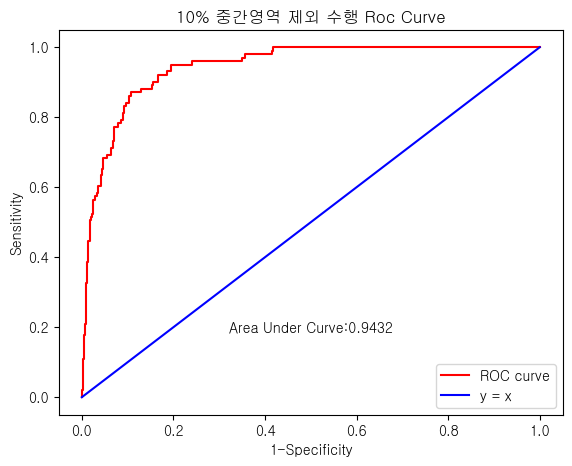

In [114]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle_10['Biopsy']), ex_copy_no_middle_10['pred_prob_1'])

plt.figure(figsize=(6.5,5))

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle_10['Biopsy']), ex_copy_no_middle_10['pred_prob_1'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('10% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [115]:
accuracy = accuracy_score(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.63%


In [116]:
print(classification_report(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred']))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       526
           1       0.83      0.45      0.58       101

    accuracy                           0.90       627
   macro avg       0.87      0.71      0.76       627
weighted avg       0.89      0.90      0.88       627



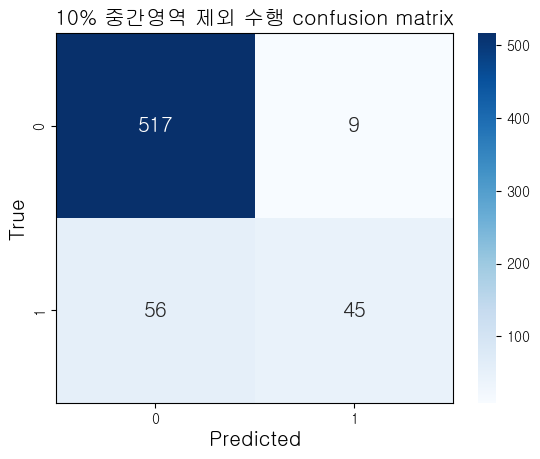

In [117]:
cm = confusion_matrix(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred'])

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('10% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

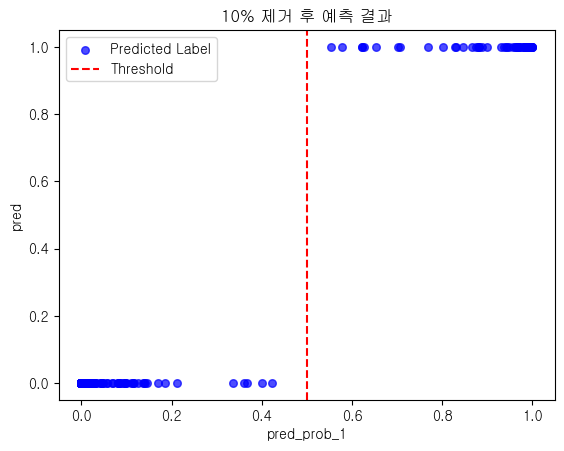

In [118]:
plt.scatter(ex_copy_no_middle_10['pred_prob_1'], ex_copy_no_middle_10['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob_1')
plt.ylabel('pred')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.show()

In [119]:
middle_10_pred_prob = np.array(ex_copy_no_middle_10['pred_prob_1'])
middle_10_pred = np.array(ex_copy_no_middle_10['pred'])

print(len(middle_10_pred_prob))
print(len(ex_copy_no_middle_10['pred_prob_1']))

627
627


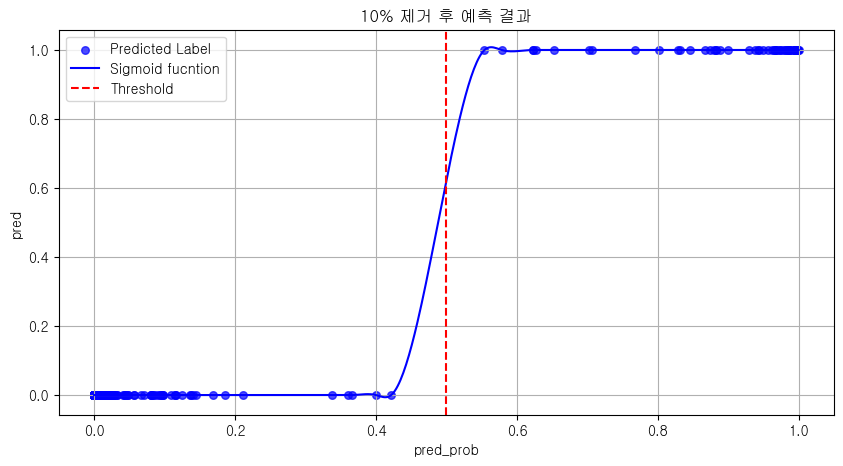

In [120]:
from scipy.interpolate import interp1d

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# 보간 함수 생성
f = interp1d(sorted_ex_copy_pred_prob, sorted_ex_copy_pred, kind='cubic')

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()


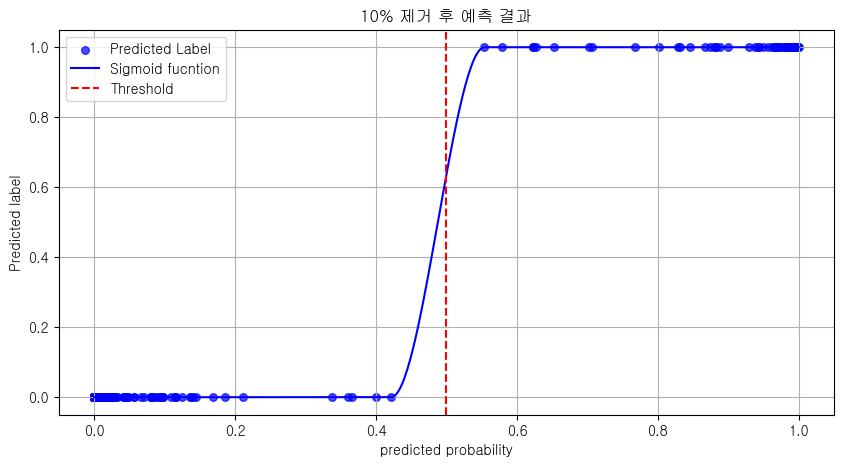

In [121]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

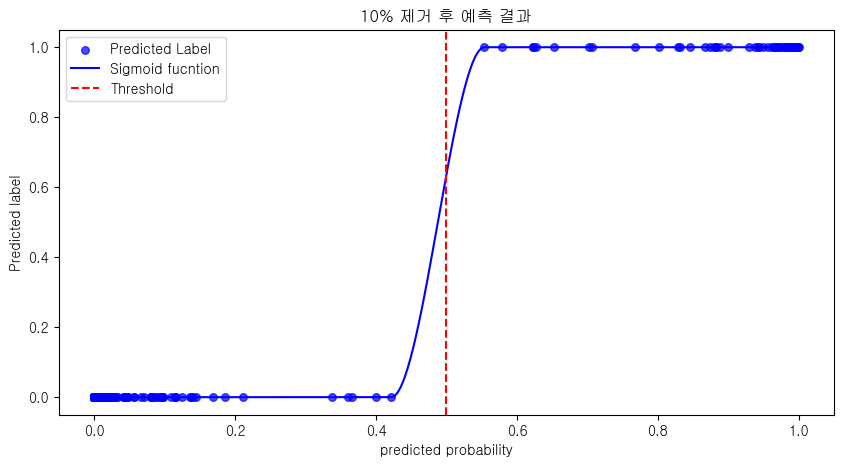

In [122]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 20% 중간 영역 제외

In [123]:
test.columns

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC'],
      dtype='object')

In [124]:
print(len(ex_copy.pred_prob_1))
ex_copy.pred_prob_1.head()

632


0    0.464096
1    0.996576
2    0.000010
3    0.000205
4    0.000026
Name: pred_prob_1, dtype: float32

In [125]:
# 8개 제외됨
ex_copy_no_middle = ex_copy[(ex_copy['pred_prob_1'] < 0.4) | (ex_copy['pred_prob_1'] > 0.6)].copy()
print(ex_copy_no_middle.shape)
ex_copy_no_middle.head()

(624, 20)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,pred,pred_prob_1,pred_prob_0
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,1,1,0.996576,0.003424
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0,0,0.000010,0.999990
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0,0,0.000205,0.999795
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0,0,0.000026,0.999974
5,60,1,0,0,255,5.1,13.2,0.95,86.653354,0.0,3.0,868.3,1.3104,114,2,5,1,1,0.976329,0.023671


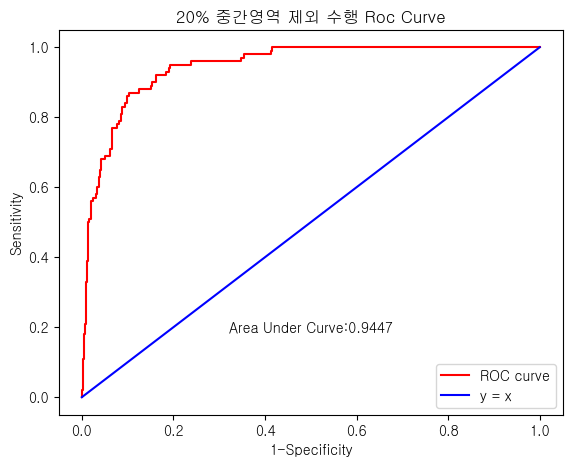

In [126]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle['Biopsy']), ex_copy_no_middle['pred_prob_1'])

plt.figure(figsize=(6.5,5))

# auc 계산
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle['Biopsy']), ex_copy_no_middle['pred_prob_1'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('20% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [127]:
accuracy = accuracy_score(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.06%


In [128]:
print(classification_report(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred']))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       524
           1       0.87      0.45      0.59       100

    accuracy                           0.90       624
   macro avg       0.88      0.72      0.77       624
weighted avg       0.90      0.90      0.89       624



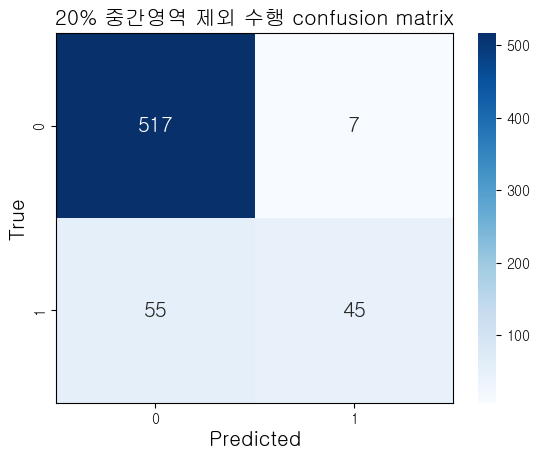

In [129]:
cm = confusion_matrix(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred'])

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('20% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

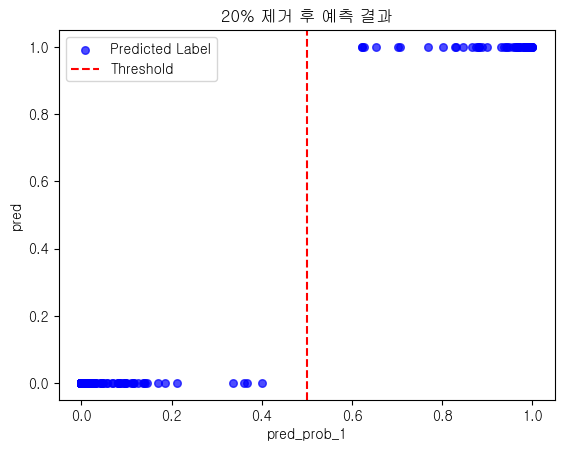

In [130]:
plt.scatter(ex_copy_no_middle['pred_prob_1'], ex_copy_no_middle['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob_1')
plt.ylabel('pred')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.show()

In [131]:
middle_pred_prob = np.array(ex_copy_no_middle['pred_prob_1'])
middle_pred = np.array(ex_copy_no_middle['pred'])

print(len(middle_pred_prob))
print(len(ex_copy_no_middle['pred_prob_1']))

624
624


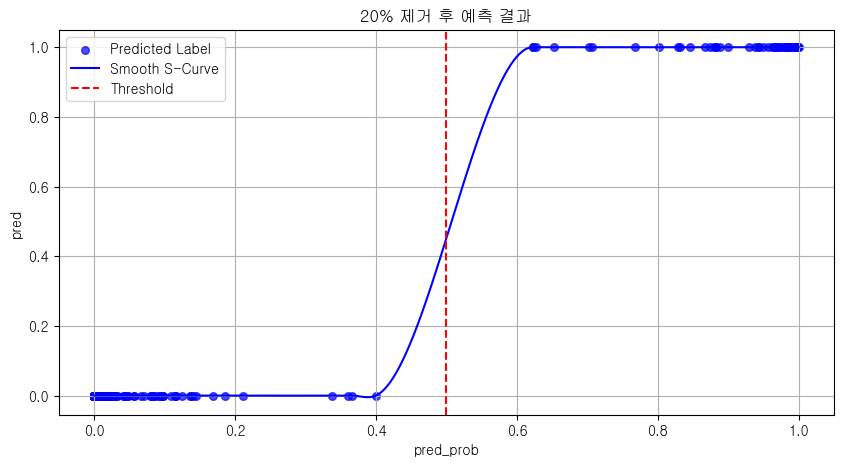

In [132]:
from scipy.interpolate import interp1d

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# 보간 함수 생성
f = interp1d(sorted_ex_copy_pred_prob, sorted_ex_copy_pred, kind='cubic')

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Smooth S-Curve')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()


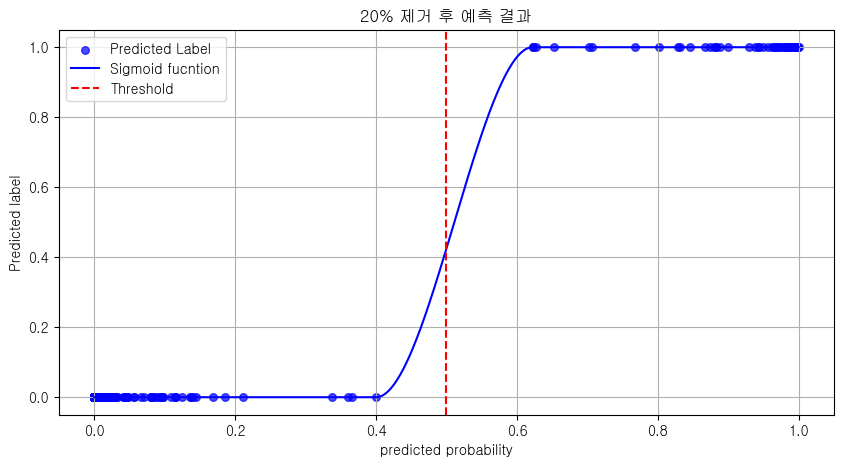

In [133]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

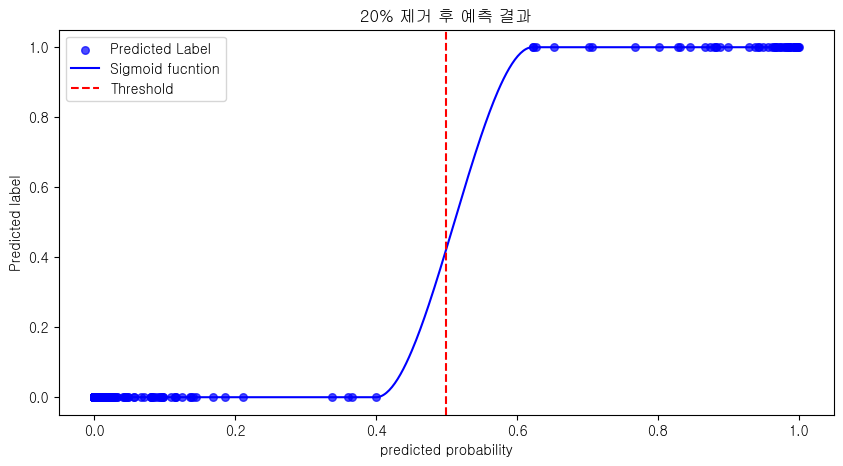

In [134]:
from scipy.interpolate import PchipInterpolator

# 격자 없이 
# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

In [137]:
ex_copy.to_csv('../data/ex_copy.csv', index=False)

ex_copy_no_middle_10.to_csv('../data/ex_copy_no_middle_10.csv', index=False)
ex_copy_no_middle.to_csv('../data/ex_copy_no_middle_20.csv', index=False)